In [16]:
import warnings
warnings.filterwarnings("ignore")
import sys,os
from six.moves import reload_module
import numpy as np
import dicom
import glob
import matplotlib
from matplotlib import pyplot as plt
#import cv2
import pandas as pd
import time
import h5py
from sklearn import cross_validation
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras import backend as K
from os import environ
import keras
from keras.preprocessing import image

### Function to extract 3d image from the slices

In [17]:
def get_3d_data(p):
    path = INPUT_FOLDER + '\\' + p
    p1 = os.listdir(path)[0]
    p2 = os.listdir(path + '\\' + p1)
    files= os.listdir(path + '\\' + p1 + '\\' + p2[0]) 
    if len(files) > 1:
        slices = [dicom.read_file(path + '\\' +p1 + '\\' + p2[0] + '\\' + s) for s in os.listdir(path + '\\' +p1 + '\\' + p2[0])]
    else:
        slices = [dicom.read_file(path + '\\' +p1 + '\\' + p2[1] + '\\' + s) for s in os.listdir(path + '\\' +p1 + '\\' + p2[1])]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    return np.stack([s.pixel_array for s in slices])

### Function to extract image cubes to be passed as input the CNN model

In [18]:
def get_image_cubes(patient):
    scan_img = get_3d_data(patient)
    scan_img[scan_img == -2000] = 0
    img_cubes = []
    for i in range(0, scan_img.shape[0] - 3, 3):
        tmp = []
        for j in range(3):
            img = scan_img[i + j] 
            img = 255.0 / np.amax(img) * img #Pixel Normalization
            img = cv2.equalizeHist(img.astype(np.uint8)) #Histogram equalization
            img = img.astype(np.uint8)
            img = img[50: 450, 50: 450] # Crop image
            img = cv2.resize(img, (224, 224))
            tmp.append(img)
        tmp = np.array(tmp)
        tmp = np.swapaxes(tmp,0,2)
        img_cubes.append(np.array(tmp))   
    img_cubes = np.array(img_cubes, dtype='int')
    return img_cubes

### Extract features from Resnet50 model (pretrained in imagenet weights)

In [19]:
INPUT_FOLDER = '.\\NSCLC-Radiomics\\'
patients = os.listdir(INPUT_FOLDER)
model = ResNet50(weights='imagenet', include_top=False)

In [20]:
for patient in patients:
    a= get_image_cubes(patient)
    feat_fold = '.\\resnet_features\\'
    feats = model.predict(img_cubes, verbose=1)
    feats = np.mean(feats,axis=0).flatten() # Average pool & Flatten operation
    np.save(os.path.join(feat_fold, patient), feats)
    break

### Splitting training and test dataset (Maintaining the same data distribution)

In [22]:
import pandas as pd
dat_all=pd.read_csv('dat_all.csv')

In [23]:
import random
class1 = list(dat_all[dat_all['class']==0]['PatientID'])
class2 = list(dat_all[dat_all['class']==1]['PatientID'])

In [24]:
class1_test = class1[0:int((len(class1)) * 0.2)]
class2_test = class2[0:int((len(class2)) * 0.2)]
test_data = class1_test + class2_test 
train_data = [x for x in dat_all['PatientID'] if x not in test_data]
train_data_labels =[]
for a in train_data:
    train_data_labels.append(list(dat_all[dat_all['PatientID']==a]['class'])[0])
test_data_labels = []
for a in test_data:
    test_data_labels.append(list(dat_all[dat_all['PatientID']==a]['class'])[0])

### Training a Fully connect Neural Network on the features extracted from Resnet model

In [27]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, ZeroPadding2D, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.optimizers import SGD
from keras.callbacks import History, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [28]:
x1 = np.array([np.load('./resnet_features/' + idd + '.npy') for idd in train_data])
y1 = np.array(train_data_labels)

In [29]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y1)
encoded_Y = encoder.transform(y1)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [30]:
model = Sequential()
model.add(Dense(2048, input_dim=2048, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
# Compile model

sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [69]:
callbacks = [EarlyStopping(monitor='val_loss', min_delta=10**-7, patience=5, verbose=1, mode='auto'),
                ModelCheckpoint('lung_cancer_lifetime_resnet.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)]
history=model.fit(x1,dummy_y, steps_per_epoch= 800,validation_steps=10, epochs=20, verbose=1, validation_split=0.2, shuffle= True, class_weight= {0: 1.0, 1: 5}, callbacks=callbacks)

Train on 270 samples, validate on 68 samples
Epoch 1/20
800/800 [==============================] - 209s 261ms/step - loss: 1.2910 - acc: 0.4150 - val_loss: 0.7546 - val_acc: 0.5735

Epoch 00001: val_loss improved from inf to 0.75462, saving model to lung_cancer_lifetime_resnet.h5
Epoch 2/20
800/800 [==============================] - 280s 350ms/step - loss: 1.0324 - acc: 0.5982 - val_loss: 0.6261 - val_acc: 0.6765

Epoch 00002: val_loss improved from 0.75462 to 0.62609, saving model to lung_cancer_lifetime_resnet.h5
Epoch 3/20
800/800 [==============================] - 276s 345ms/step - loss: 0.7984 - acc: 0.7436 - val_loss: 0.5145 - val_acc: 0.7794

Epoch 00003: val_loss improved from 0.62609 to 0.51446, saving model to lung_cancer_lifetime_resnet.h5
Epoch 4/20
800/800 [==============================] - 289s 361ms/step - loss: 0.5590 - acc: 0.8548 - val_loss: 0.4231 - val_acc: 0.7941

Epoch 00004: val_loss improved from 0.51446 to 0.42315, saving model to lung_cancer_lifetime_resnet.h5

['acc', 'loss', 'val_acc', 'val_loss']


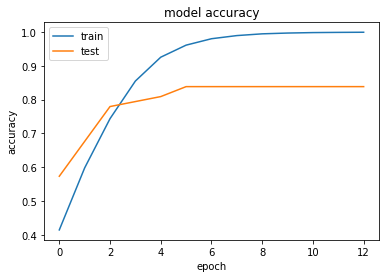

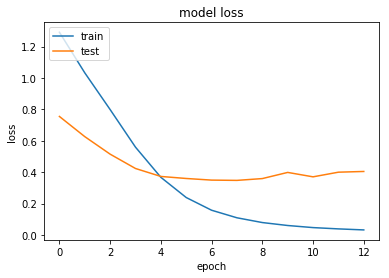

In [70]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluating Model on test data

In [19]:
test_x = np.array([np.load('./resnet_features/' + idd + '.npy') for idd in test_data])
test_y = np.array(test_data_labels)

In [23]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(test_y)
encoded_Y = encoder.transform(test_y)
dummy_test_y = np_utils.to_categorical(encoded_Y)

In [24]:
print (model.evaluate(test_x,dummy_test_y, verbose=1))

print (model.metrics_names)

84/84 [==============================] - 0s 3ms/step
[0.9076082025255475, 0.7261904761904762]
['loss', 'acc']


### ROC curve

In [25]:
y_pred_keras = model.predict_proba(test_x)
y_pred =[]
for a in y_pred_keras:
    if a[0] > a[1]:
        y_pred.append(0)
    else:
        y_pred.append(1)
y_pred = np.array(y_pred)

In [27]:
from sklearn.metrics import roc_curve, auc
y_pred_keras = model.predict_proba(test_x)
fpr_keras_resnet, tpr_keras_resnet, thresholds_keras = roc_curve(test_y.ravel(), y_pred.ravel())
roc_auc = auc(fpr_keras_resnet, tpr_keras_resnet)

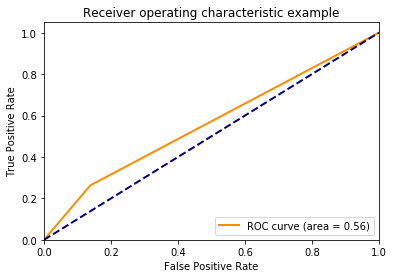

In [28]:
plt.figure()
lw = 2
plt.plot(fpr_keras_resnet, tpr_keras_resnet, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

In [29]:
preds = []
for a in y_pred_keras:
    if a[0] > a[1]:
        preds.append(0)
    else:
        preds.append(1)

[[0.86153846 0.13846154]
 [0.73684211 0.26315789]]


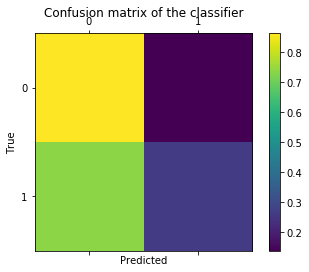

In [30]:
from sklearn.metrics import confusion_matrix

labels = [0, 1]
cm = confusion_matrix(test_data_labels, preds, labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()